# DIOMIRA

Leaving there and proceeding for three days toward the east, you reach Diomira, a city with sixty silver domes, bronze statues of all the gods, streets paved with lead, a crystal theater, a golden cock that crows every morning on a tower. All these beauties will already be familiar to the visitor, who has seen them also in other cities. But the special quality of this city for the man who arrives there on a September evening, when the days are growing shorter and the multicolored lamps are lighted all at once at the doors of the food stalls and from a terrace a woman's voice cries ooh!, is that he feels envy toward those who now believe they have once before lived an evening identical to this and who think they were happy, that time.

In [1]:
from __future__ import print_function

In [2]:
from IPython.display import Image

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


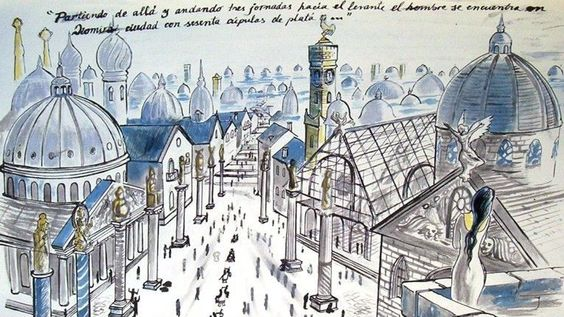

In [4]:
Image(filename='../Images/Diomira.jpg') 

## DIOMIRA notebook 

DIOMIRA
        1. Reads an MCRD file produced by art/centella, which stores MCRD waveforms for PMTs (bins of 1 ns)
        and the SiPMs (bins of 1 mus)
            

        2. Simulates the response of the energy plane in the PMTs MCRD, and produces both RWF and TWF:
        see: http://localhost:8931/notebooks/Nh5-Event-Model.ipynb#Reconstructed-Objects
        
            
        3. Simulates the response of the tracking plane in the SiPMs MCRD and outputs
            SiPM RWF (not yet implemented, for the time being simply copy the MCRD)

        4. Add a table describing the FEE parameters used for simulation

        5. Copies the tables on geometry, detector data and MC

In [5]:
import logging
import sys
logger = logging.getLogger()
logger.handlers[0].stream = sys.stdout
logger.setLevel(logging.DEBUG)

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import tables 
import numpy as np

### Configuration

#### Configure.py

In [7]:
import getopt

In [8]:
def cdf_to_dict(cdf):
    """
    transforms the configuration data frame into a dictionary
    """

    dc ={}
    for k in cdf.keys():
        dc[k] = cdf[k][0]
    return dc
    

def usage(program_name):
    """
    Usage of program
    """
    print("""

        Usage: python (run) {} [args]


        where args are:
         -h (--help) : this text
         -i (--info) : print a text describing the invisible city of DIOMIRA
         -d (--debug) : can be set to 'DEBUG','INFO','WARNING','ERROR'
         -c (--cfile) : full path to a configuration file
         
         example of configuration file 

         # comment line  
        Names of parameters (comma separated)
        Values of parameters (comma separated)
        
        The parameters for DIOMIRA are:

        PATH_IN = path to input DST file (must be a MCRD file)
        FILE_IN = name of input DST file
        PATH_OUT = path to output DST file (RWF file)
        FILE_OUT = name of ouput DST file (RWF file)
        FIRST_EVT,LAST_EVT,RUN_ALL,

        RUN_ALL is used to decide whether to run all the events in the file
        in case that the total number of events requested (LAST_EVT-FIRST_EVT) 
        exceeds the number of events in the DST file. If RUN_ALL is set to 1 (True), 
        the script will run over all elements in the DST, 
        otherwise it will exit with a warning.


        """.format(program_name))

def configure(pname,argv):


    """
    reads arguments from the command line and configures job
    """
    
    #print("argv ={}".format(argv))
    
    DEBUG='INFO'
    INFO = False
    cfile =''

    try:
        opts, args = getopt.getopt(argv, "hid:c:", ["help","info","debug","cfile"])

    except getopt.GetoptError:
        usage(pname)
        raise KeyError("An error has occured parsing getopt")

    #print("opts ={}".format(opts))

    for opt, arg in opts:
        #print("opt ={}, arg = {}".format(opt,arg))
        if opt in ("-h", "--help"):
            usage(pname)
            raise KeyError("Not really an error. Ignore")
        elif opt in ("-d", "--debug"):
            DEBUG = arg
        elif opt in ("-i", "--info"):
            INFO = True
        elif opt in ("-c", "--cfile"):
            cfile = arg
 
    lg = 'logging.'+DEBUG
    #print('INFO = {} DEBUG={}'.format(INFO,DEBUG))
    #print("lg ={}".format(lg))
    logger.setLevel(eval(lg))

    if cfile == '':
        print("Path to configuration file not given")
        usage(pname)
        raise KeyError("Please, specify your path")

    cfp =pd.read_csv(cfile,comment="#")
    # print("""
    #     Configuration parameters \n 
    #     {}
    #     """.format(cfp))

    CFP = cdf_to_dict(cfp)
    
    logger.info("ConFiguration Parameters (CFP) dictionary  = {}".format(CFP))
    return INFO, CFP
    

In [9]:
INFO, CFP = configure("DIOMIRA",['-i','-d','DEBUG','-c','/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Config/DOROTEA_NA_ZLIB_test.csv'])

INFO:root:ConFiguration Parameters (CFP) dictionary  = {'FIRST_EVT': 0, 'LAST_EVT': 100, 'END ': 1, 'RUN_ALL': 1, 'PATH_IN': '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/Prod0/', 'FILE_IN': 'WF_Na_0.h5'}


In [10]:
INFO

True

In [11]:
CFP

{'END ': 1,
 'FILE_IN': 'WF_Na_0.h5',
 'FIRST_EVT': 0,
 'LAST_EVT': 100,
 'PATH_IN': '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/Prod0/',
 'RUN_ALL': 1}

### Sensors response

#### Produce TWF by rebinning MCRD rather than by decimation

##### Rebinning

In [26]:
data = sin(np.linspace(0, pi, 1000))

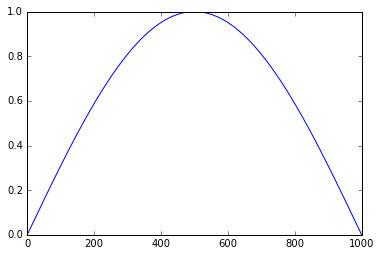

In [27]:
plt.plot(data)

In [28]:
area =np.sum(data)

In [29]:
area

635.98262847222895

In [38]:
def rebin_array(a, stride):
    """
    rebins the array according to stride 
    """
    lenb = len(a)/int(stride)
    b = np.zeros(lenb)
    j=0
    for i in range(lenb):
        b[i] = np.sum(a[j:j+stride])
        j+= stride
    return b
        

In [39]:
data_rb = rebin_array(data, 10)

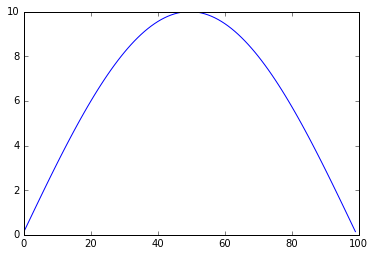

In [40]:
plt.plot(data_rb)

In [41]:
area_rb =np.sum(data_rb)

In [42]:
area_rb

635.98262847222884

#### SensorsResponse.py

In [52]:
import FEParam as FP
import SPE as SP
import FEE2 as FE
from FEE2 import down_scale_signal_

def FEE_param_table(fee_table):
    """
    Stores the parameters of the EP FEE simulation 
    """
    row = fee_table.row
    row['offset'] = FP.offset
    row['pmt_gain'] = FP.PMT_GAIN
    row['V_gain'] = FP.V_GAIN
    row['R'] = FP.R
    row['C12'] = FP.C12
    row['CO12'] = FP.C12 # to be rewritten by ISIDORA
    row['time_step'] = FP.time_step
    row['time_daq'] = FP.time_DAQ
    row['freq_LPF'] = FP.freq_LPF
    row['freq_HPF'] = 1./(2*pi*FP.R*FP.C)
    row['LSB'] = FP.LSB
    row['volts_to_adc'] = FP.voltsToAdc/volt
    row['noise_fee_rms'] = FP.NOISE_FEE
    row['noise_adc'] = FP.NOISE_ADC
    
    row.append()
    

def energy_pes(event_number, sensord):
    """
    Sum the WFs of PMTs and SiPMs (MC) and store the total energy in PES
    """     
    rdata = []

    for j in range(sensord.shape[1]):
        swf = sensord[event_number, j]
        ene = np.sum(swf)
        rdata.append(ene)
        
    return np.array(rdata) 

def simulate_sipm_response(event_number,sipmrd_):
    """
    For the moment use a dummy rutne that simply copies the sipm EARRAY
    """
    rdata = []

    for j in range(sipmrd_.shape[1]):
        logger.debug("-->SiPM number ={}".format(j))
        rdata.append(sipmrd_[event_number, j])
    return np.array(rdata)


def simulate_pmt_response(event_number,pmtrd_):
    """
    Given a MCRD signal in PE (photoelectrons in bins of 1 ns) and the response function of 
    for a single photoelectron (spe) and front-end electronics (fee)
    this function produces RWF (adc counts bins 25 ns)

    pmtrd_ dataset that holds the PMT PE data for each PMT

    """
  
    rdata = []

    for j in range(pmtrd_.shape[1]):
        logger.debug("-->PMT number ={}".format(j))
                
        pmt = pmtrd_[event_number, j] #waveform for event event_number, PMT j
        
        fee = FE.FEE(C=FP.C12[j],R= FP.R, f=FP.freq_LPF, RG=FP.V_GAIN) 
        spe = SP.SPE(pmt_gain=FP.PMT_GAIN,x_slope = 5*ns,x_flat = 1*ns)
    
        signal_PMT = spe.SpePulseFromVectorPE(pmt) #PMT response

        #Front end response to PMT pulse (in volts)
        signal_fee = fee.FEESignal(signal_PMT, noise_rms=FP.NOISE_FEE) 

        #Signal out of DAQ
        signal_daq = fee.daqSignal(signal_fee, noise_rms=0)

        rdata.append(signal_daq)
    return np.array(rdata)

def decimate_signal(event_number,pmtrd_):
    """
    Decimates the MCRD signal to produce TWF (pes, bins 25 ns)
    """
  
    rdata = []

    for j in range(pmtrd_.shape[1]):
        logger.debug("-->PMT number ={}".format(j))
                
        pmt = pmtrd_[event_number, j] #waveform for event event_number, PMT j
        twf = down_scale_signal_(pmt, int(FP.time_DAQ))
        
        
        rdata.append(twf)
    return np.array(rdata)

def rebin_array(a,stride):
    """
    rebins array a according to stride
    """
    
    lenb = (len(a)+1)/int(stride)
    b = np.zeros(lenb)
    j=0
    for i in range(lenb):
        b[i] = np.sum(a[j:j+stride])
        j+= stride
    return b

def rebin_signal(event_number,pmtrd_):
    """
    rebins the MCRD signal to produce TWF (pes, bins 25 ns)
    """
    
    rdata = []

    for j in range(pmtrd_.shape[1]):
        logger.debug("-->PMT number ={}".format(j))
                
        pmt = pmtrd_[event_number, j] #waveform for event event_number, PMT j
        twf = rebin_array(pmt, int(FP.time_DAQ))
        
        rdata.append(twf)
    return np.array(rdata)

  



### DIOMIRA

#### DIOMIRA.py

In [50]:
from Nh5 import *
from Util import *
from cities import diomira
def DIOMIRA(argv):
    INFO, CFP = configure(argv[0],argv[1:])
   
    if INFO:
        print(diomira)

    wait()
    
    print("""
        DIOMIRA:
         1. Reads an MCRD file produced by art/centella, which stores MCRD 
         waveforms for PMTs (bins of 1 ns)
        and the SiPMs (bins of 1 mus)
            

        2. Simulates the response of the energy plane in the PMTs MCRD, 
        and produces both RWF and TWF:
        see: http://localhost:8931/notebooks/Nh5-Event-Model.ipynb#Reconstructed-Objects
        
            
        3. Simulates the response of the tracking plane in the SiPMs MCRD and outputs
            SiPM RWF (not yet implemented, for the time being simply copy the MCRD)

        4. Add a table describing the FEE parameters used for simulation

        5. Copies the tables on geometry, detector data and MC


        """)
    FP.print_FEE()
    wait()

    PATH_IN =CFP['PATH_IN']
    PATH_OUT =CFP['PATH_OUT']
    FILE_IN =CFP['FILE_IN']
    FILE_OUT =CFP['FILE_OUT']
    FIRST_EVT =CFP['FIRST_EVT']
    LAST_EVT =CFP['LAST_EVT']
    RUN_ALL =CFP['RUN_ALL']
    NEVENTS = LAST_EVT - FIRST_EVT

    logger.info("input path ={}; output path = {}; file_in ={} file_out ={}".format(
        PATH_IN,PATH_OUT,FILE_IN, FILE_OUT))

    logger.info("first event = {} last event = {} nof events requested = {} ".format(
        FIRST_EVT,LAST_EVT,NEVENTS))

    # open the input file 
    with tables.open_file("{}/{}".format(PATH_IN,FILE_IN), "r+") as h5in: 
        # access the PMT raw data in file 
        pmtrd_ = h5in.root.pmtrd
        sipmrd_ = h5in.root.sipmrd

        #pmtrd_.shape = (nof_events, nof_sensors, wf_length)
        NPMT = pmtrd_.shape[1]
        NSIPM = sipmrd_.shape[1]
        PMTWL = pmtrd_.shape[2] 
        PMTWL_FEE = int((PMTWL+1)/FP.time_DAQ)
        SIPMWL = sipmrd_.shape[2]
        NEVENTS_DST = pmtrd_.shape[0]

        logger.info("nof PMTs = {} nof  SiPMs = {} nof events in input DST = {} ".format(
        NPMT,NSIPM,NEVENTS_DST))

        logger.info("lof SiPM WF = {} lof PMT WF (MC) = {} lof PMT WF (FEE) = {}".format(
        PMTWL,SIPMWL,PMTWL_FEE))

        wait()

        #access the geometry and the sensors metadata info

        geom_t = h5in.root.Detector.DetectorGeometry
        pmt_t = h5in.root.Sensors.DataPMT
        sipm_t = h5in.root.Sensors.DataSiPM
        mctrk_t = h5in.root.MC.MCTracks

        
        # open the output file 
        with tables.open_file("{}/{}".format(PATH_OUT,FILE_OUT), "w",
            filters=tables.Filters(complib="blosc", complevel=9)) as h5out:
 
            # create a group to store MC data
            mcgroup = h5out.create_group(h5out.root, "MC")
            # copy the mctrk table
            mctrk_t.copy(newparent=mcgroup)

            # create a group  to store geom data
            detgroup = h5out.create_group(h5out.root, "Detector")
            # copy the geom table
            geom_t.copy(newparent=detgroup)

            # create a group  store sensor data
            sgroup = h5out.create_group(h5out.root, "Sensors")
            # copy the pmt table
            pmt_t.copy(newparent=sgroup)
            # copy the sipm table
            sipm_t.copy(newparent=sgroup)

            # create a table to store Energy plane FEE data and hang it from MC group
            fee_table = h5out.create_table(mcgroup, "FEE", FEE,
                          "EP-FEE parameters",
                           tables.Filters(0))

            # fill table
            FEE_param_table(fee_table)

            # create a group to store RawData
            rgroup = h5out.create_group(h5out.root, "RD")
            
            # create an extensible array to store the RWF waveforms
            pmtrwf = h5out.create_earray(h5out.root.RD, "pmtrwf", 
                                    atom=tables.IntAtom(), 
                                    shape=(0, NPMT, PMTWL_FEE), 
                                    expectedrows=NEVENTS_DST)
            
            # create an extensible array to store the TWF waveforms
            pmttwf = h5out.create_earray(h5out.root.RD, "pmttwf", 
                                    atom=tables.IntAtom(), 
                                    shape=(0, NPMT, PMTWL_FEE), 
                                    expectedrows=NEVENTS_DST)
            

            sipmrwf = h5out.create_earray(h5out.root.RD, "sipmrwf", 
                                    atom=tables.IntAtom(), 
                                    shape=(0, NSIPM, SIPMWL), 
                                    expectedrows=NEVENTS_DST)

            #create an extensible array to store the energy in PES of PMTs 
            epmt = h5out.create_earray(h5out.root.RD, "epmt", 
                                    atom=tables.IntAtom(), 
                                    shape=(0, NPMT), 
                                    expectedrows=NEVENTS_DST)

            # create an extensible array to store the energy in PES of SiPMs 
            esipm = h5out.create_earray(h5out.root.RD, "esipm", 
                                    atom=tables.IntAtom(), 
                                    shape=(0, NSIPM), 
                                    expectedrows=NEVENTS_DST)

            
            if NEVENTS > NEVENTS_DST and RUN_ALL == False:
                print("""
                Refusing to run: you have requested
                FIRST_EVT = {}
                LAST_EVT  = {}
                Thus you want to run over {} events
                but the size of the DST is {} events.
                Please change your choice or select RUN_ALL = TRUE
                to run over the whole DST when this happens
                """.format(FIRST_EVT,LAST_EVT,NEVENTS,NEVENTS_DST))
                sys.exit(0)
            elif  NEVENTS > NEVENTS_DST and RUN_ALL == True:
                FIRST_EVT = 0
                LAST_EVT = NEVENTS_DST
                NEVENTS = NEVENTS_DST


            for i in range(FIRST_EVT,LAST_EVT):
                logger.info("-->event number ={}".format(i))

                #simulate PMT response and return an array with RWF
                dataPMT = simulate_pmt_response(i,pmtrd_)
                
                #TWF
                 
                truePMT = rebin_signal(i,pmtrd_)
                
                
                #RWF for pmts
                pmtrwf.append(dataPMT.reshape(1, NPMT, PMTWL_FEE))
                #pmtrd.append(dataPMT.reshape(1, NPMT, PMTWL))
                
                #TWF for pmts
                pmttwf.append(truePMT.reshape(1, NPMT, PMTWL_FEE))
                #pmtrd.append(dataPMT.reshape(1, NPMT, PMTWL))
                   
                #simulate SiPM response and return an array with new WF
                dataSiPM = simulate_sipm_response(i,sipmrd_)
                
                #append to SiPM EARRAY
                sipmrwf.append(dataSiPM.reshape(1, NSIPM, SIPMWL))

                #fill ene_pmt vector
                enePMT = energy_pes(i, pmtrd_)
                #append to epmt EARRAY
                epmt.append(enePMT.reshape(1, NPMT))

                #fill ene_sipm vector
                eneSIPM = energy_pes(i, sipmrd_)
                esipm.append(eneSIPM.reshape(1, NSIPM))

            pmtrwf.flush()
            pmttwf.flush()
            sipmrwf.flush()
            epmt.flush()
            esipm.flush()


    print("Leaving Diomira. Safe travels!")


### Configuration file

In [48]:
!less ../Config/DIOMIRA_NA_ZLIB_test.csv

# Configuration file for DIOMIRA
# The parameters for DIOMIRA are:
#
#        PATH_IN = path to input DST file (must be a MCRD file)
#        FILE_IN = name of input DST file
#        PATH_OUT = path to output DST file (RWF file)
#        FILE_OUT = name of ouput DST file (RWF file)
#        FIRST_EVT,LAST_EVT,RUN_ALL,
#
#        RUN_ALL is used to decide whether to run all the events in the file
#        in case that the total number of events requested (LAST_EVT-FIRST_EVT) 
#        exceeds the number of events in the DST file. If RUN_ALL is set to 1 (T rue), 
#        the script will run over all elements in the DST, 
#        otherwise it will exit with a warning.
#
PATH_IN,PATH_OUT,FILE_IN,FILE_OUT,FIRST_EVT,LAST_EVT,RUN_ALL,END 
/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/WF-NA-ZLIB/,/Use rs/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/,WF_Na_1Kevts_c omp1_chunk32k.h5,WF_Na_test_RWF.h5,0,10,1,1
(END)

####  DIOMIRA main

In [53]:
DIOMIRA(["DIOMIRA",'-i','-d','INFO','-c','/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Config/DIOMIRA_NA_ZLIB_test.csv'])

INFO:root:ConFiguration Parameters (CFP) dictionary  = {'FIRST_EVT': 0, 'LAST_EVT': 10, 'FILE_OUT': 'WF_Na_test_RWF.h5', 'PATH_OUT': '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/', 'END ': 1, 'RUN_ALL': 1, 'PATH_IN': '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/WF-NA-ZLIB/', 'FILE_IN': 'WF_Na_1Kevts_comp1_chunk32k.h5'}

Leaving there and proceeding for three days toward the east, you reach Diomira, 
a city with sixty silver domes, bronze statues of all the gods, streets paved with lead, 
a crystal theater, a golden cock that crows every morning on a tower. 
All these beauties will already be familiar to the visitor, 
who has seen them also in other cities. 
But the special quality of this city for the man who arrives there on a September evening, 
when the days are growing shorter 
and the multicolored lamps are lighted all at once at the doors of the food stalls 
and from a terrace a woman's voice cries ooh!, is that he feels envy 
toward t

### Checking the file

In [54]:
ls '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_test_RWF.h5'

/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_test_RWF.h5


In [55]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_test_RWF.h5', "r+") 

In [56]:
h5f

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_test_RWF.h5, title='', mode='r+', root_uep='/', filters=Filters(complevel=9, complib='blosc', shuffle=True, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
  description := {
  "x_det": Float64Col(shape=(2,), dflt=0.0, pos=0),
  "y_det": Float64Col(shape=(2,), dflt=0.0, pos=1),
  "z_det": Float64Col(shape=(2,), dflt=0.0, pos=2),
  "r_det": Float64Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (1170,)
/MC (Group) ''
/MC/FEE (Table(1,)) 'EP-FEE parameters'
  description := {
  "offset": Int16Col(shape=(), dflt=0, pos=0),
  "pmt_gain": Float32Col(shape=(), dflt=0.0, pos=1),
  "V_gain": Float32Col(shape=(), dflt=0.0, pos=2),
  "R": Float32Col(shape=(), dflt=0.0, pos=3),
  "C12": Float32Col(shape=(12,), dflt=0.0, pos=4),
  "CO12": Float32Col(shape=(12,), dflt=0.0, pos=5),
  "time_step": Float32Col(s

In [57]:
pmttwf = h5f.root.RD.pmttwf

In [58]:
pmttwf

/RD/pmttwf (EArray(10, 12, 24000), shuffle, blosc(9)) ''
  atom := Int32Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 5, 24000)

In [59]:
pmt0 = pmttwf[0,0]

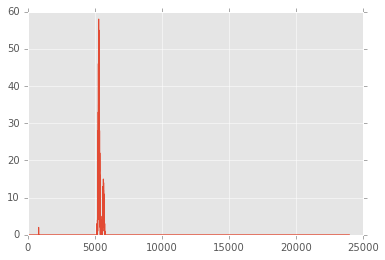

In [60]:
plt.plot(pmt0)

In [61]:
pmtrwf = h5f.root.RD.pmtrwf

In [62]:
pmtr0 = pmtrwf[0,0]

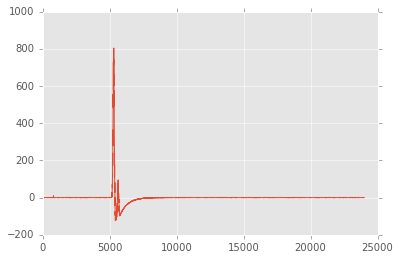

In [63]:
plt.plot(pmtr0)

In [64]:
pmt0_zs = [x for x in pmt0 if x != 0]

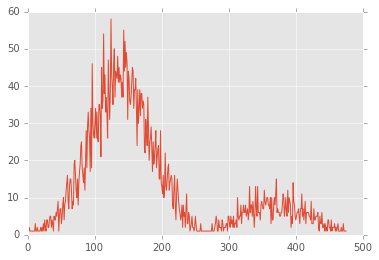

In [65]:
plt.plot(pmt0_zs)

In [66]:
def plts(signal, signal_start=0, signal_end=1e+4, offset=5):

    ax1 = plt.subplot(1,1,1)
    ymin =np.amin(signal[signal_start:signal_end]) - offset
    ymax =np.amax(signal[signal_start:signal_end]) + offset
    ax1.set_xlim([signal_start, signal_end])
    ax1.set_ylim([ymin, ymax])
    plt.plot(signal)

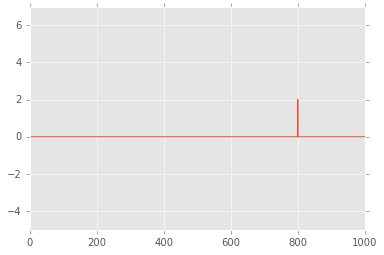

In [68]:
plts(pmt0, signal_start=0, signal_end=1000, offset=5)

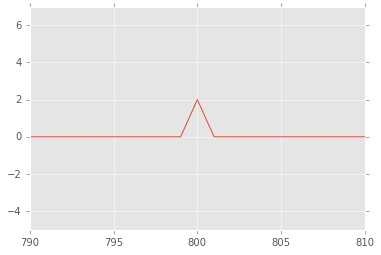

In [69]:
plts(pmt0, signal_start=790, signal_end=810, offset=5)

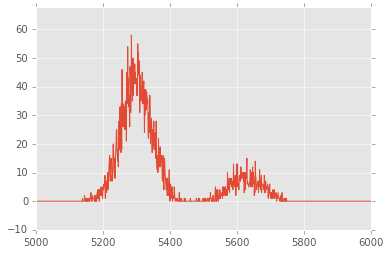

In [70]:
plts(pmt0, signal_start=5000, signal_end=6000, offset=10)

In [71]:
erec = np.sum(pmt0)

In [72]:
erec

5925

In [73]:
epmt = h5f.root.RD.epmt

In [74]:
epmt[0,0]  #energy in pes for event 0 pmt 0

5925

### Plotting waveforms

In [75]:
from PlotUtil import *

In [76]:
def plot_waveforms(pmtwfdf, maxlen=0):
    """
    Takes as input a df storing the PMT wf and plots the 12 PMT WF
    """
    
    plt.figure(figsize=(12,12))
    
    len_pmt = len(pmtwfdf[0])
    
    if maxlen > 0:
        len_pmt = maxlen
    for i in range(12):
        ax1 = plt.subplot(3,4,i+1)
        ax1.set_xlim([0, len_pmt])
        SetPlotLabels(xlabel='samples', ylabel='adc')
        plt.plot(pmtwfdf[i])

    
    plt.show()

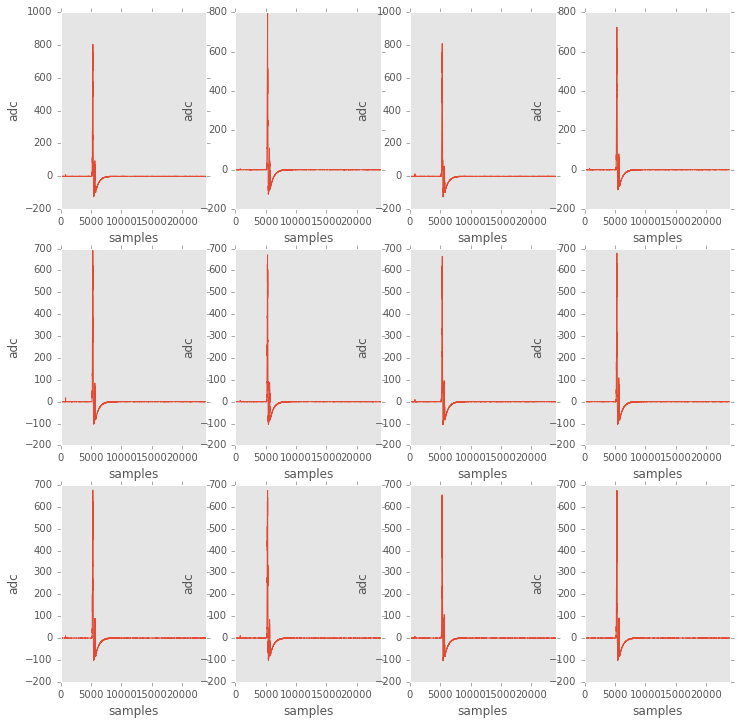

In [77]:
plot_waveforms(pmtrwf[0]) 

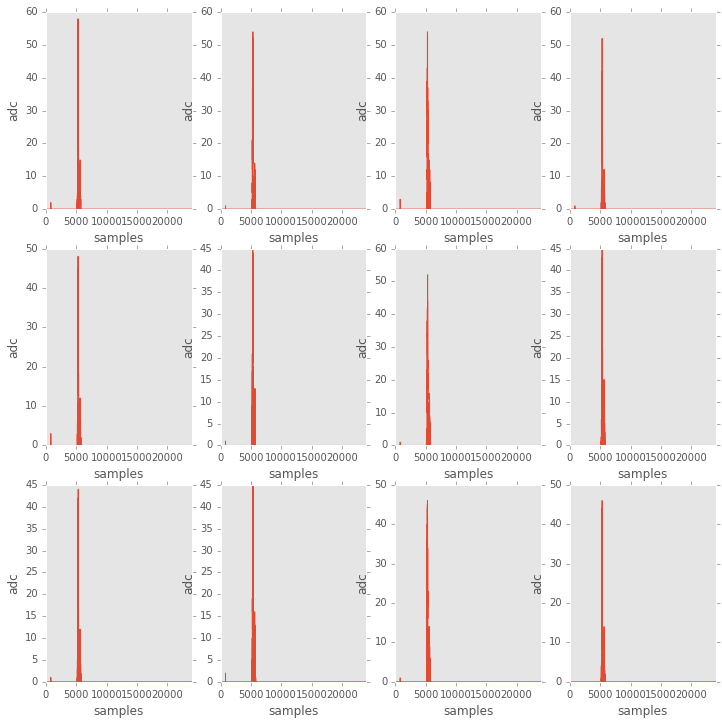

In [78]:
plot_waveforms(pmttwf[0]) 

### Running Script

In [79]:
!less ../Config/DIOMIRA_NA_ZLIB.csv

# Configuration file for DIOMIRA
# The parameters for DIOMIRA are:
#
#        PATH_IN = path to input DST file (must be a MCRD file)
#        FILE_IN = name of input DST file
#        PATH_OUT = path to output DST file (RWF file)
#        FILE_OUT = name of ouput DST file (RWF file)
#        FIRST_EVT,LAST_EVT,RUN_ALL,
#
#        RUN_ALL is used to decide whether to run all the events in the file
#        in case that the total number of events requested (LAST_EVT-FIRST_EVT) 
#        exceeds the number of events in the DST file. If RUN_ALL is set to 1 (T rue), 
#        the script will run over all elements in the DST, 
#        otherwise it will exit with a warning.
#
PATH_IN,PATH_OUT,FILE_IN,FILE_OUT,FIRST_EVT,LAST_EVT,RUN_ALL,END 
/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/WF-NA-ZLIB/,/Use rs/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/,WF_Na_1Kevts_c omp1_chunk32k.h5,WF_Na_1k.h5,0,1000,1,1
(END)

In [80]:
%time %run ../Cities/DIOMIRA.py -c ../Config/DIOMIRA_NA_ZLIB.csv

INFO:root:Configuration Parameters (CFP) dictionary  = {'FIRST_EVT': 0, 'LAST_EVT': 1000, 'FILE_OUT': 'WF_Na_1k.h5', 'PATH_OUT': '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/', 'END ': 1, 'RUN_ALL': 1, 'PATH_IN': '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/WF-NA-ZLIB/', 'FILE_IN': 'WF_Na_1Kevts_comp1_chunk32k.h5'}


Configuration Parameters (CFP) dictionary  = {'FIRST_EVT': 0, 'LAST_EVT': 1000, 'FILE_OUT': 'WF_Na_1k.h5', 'PATH_OUT': '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/', 'END ': 1, 'RUN_ALL': 1, 'PATH_IN': '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/WF-NA-ZLIB/', 'FILE_IN': 'WF_Na_1Kevts_comp1_chunk32k.h5'}


Press a key...

        DIOMIRA:
         1. Reads an MCRD file produced by art/centella, which stores MCRD 
         waveforms for PMTs (bins of 1 ns)
        and the SiPMs (bins of 1 mus)
            

        2. Simulates the response of the energy plane in the PMTs MCRD, 
        and produces both RWF and TWF:
        see: http://localhost:8931/notebooks/Nh5-Event-Model.ipynb#Reconstructed-Objects
        
            
        3. Simulates the response of the tracking plane in the SiPMs MCRD and outputs
            SiPM RWF (not yet implemented, for the time being simply copy the MCRD)

        4. Add a table describing the FEE parameters used for simulation

        5. Copies the tables on geometry, detector data and MC


        

  NEW FEE: DEFAULT PARAMETERS
  PMT gain = 4.5e+06
  sampling time: (fine) =    1.00 ns (DAQ) =   25.00 ns 
  decoupling capacitor =    6.20 nF
  decoupling resistor = 2350.00 ohm
  HPF frequency = 10923.47 Hz  W_HPF_fine = 1.1e-05 W_HPF_daq = 0.00027 


input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/WF-NA-ZLIB/; output path = /Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =WF_Na_1Kevts_comp1_chunk32k.h5 file_out =WF_Na_1k.h5


INFO:root:first event = 0 last event = 1000 nof events requested = 1000 


first event = 0 last event = 1000 nof events requested = 1000 


INFO:root:nof PMTs = 12 nof  SiPMs = 1792 nof events in input DST = 1000 


nof PMTs = 12 nof  SiPMs = 1792 nof events in input DST = 1000 


INFO:root:lof SiPM WF = 599999 lof PMT WF (MC) = 600 lof PMT WF (FEE) = 24000


lof SiPM WF = 599999 lof PMT WF (MC) = 600 lof PMT WF (FEE) = 24000


Press a key...
INFO:root:-->event number =0


-->event number =0


INFO:root:-->event number =1


-->event number =1


INFO:root:-->event number =2


-->event number =2


INFO:root:-->event number =3


-->event number =3


INFO:root:-->event number =4


-->event number =4


INFO:root:-->event number =5


-->event number =5


INFO:root:-->event number =6


-->event number =6


INFO:root:-->event number =7


-->event number =7


INFO:root:-->event number =8


-->event number =8


INFO:root:-->event number =9


-->event number =9


INFO:root:-->event number =10


-->event number =10


INFO:root:-->event number =11


-->event number =11


INFO:root:-->event number =12


-->event number =12


INFO:root:-->event number =13


-->event number =13


INFO:root:-->event number =14


-->event number =14


INFO:root:-->event number =15


-->event number =15


INFO:root:-->event number =16


-->event number =16


INFO:root:-->event number =17


-->event number =17


INFO:root:-->event number =18


-->event number =18


INFO:root:-->event number =19


-->event number =19


INFO:root:-->event number =20


-->event number =20


INFO:root:-->event number =21


-->event number =21


INFO:root:-->event number =22


-->event number =22


INFO:root:-->event number =23


-->event number =23


INFO:root:-->event number =24


-->event number =24


INFO:root:-->event number =25


-->event number =25


INFO:root:-->event number =26


-->event number =26


INFO:root:-->event number =27


-->event number =27


INFO:root:-->event number =28


-->event number =28


INFO:root:-->event number =29


-->event number =29


INFO:root:-->event number =30


-->event number =30


INFO:root:-->event number =31


-->event number =31


INFO:root:-->event number =32


-->event number =32


INFO:root:-->event number =33


-->event number =33


INFO:root:-->event number =34


-->event number =34


INFO:root:-->event number =35


-->event number =35


INFO:root:-->event number =36


-->event number =36


INFO:root:-->event number =37


-->event number =37


INFO:root:-->event number =38


-->event number =38


INFO:root:-->event number =39


-->event number =39


INFO:root:-->event number =40


-->event number =40


INFO:root:-->event number =41


-->event number =41


INFO:root:-->event number =42


-->event number =42


INFO:root:-->event number =43


-->event number =43


INFO:root:-->event number =44


-->event number =44


INFO:root:-->event number =45


-->event number =45


INFO:root:-->event number =46


-->event number =46


INFO:root:-->event number =47


-->event number =47


INFO:root:-->event number =48


-->event number =48


INFO:root:-->event number =49


-->event number =49


INFO:root:-->event number =50


-->event number =50


INFO:root:-->event number =51


-->event number =51


INFO:root:-->event number =52


-->event number =52


INFO:root:-->event number =53


-->event number =53


INFO:root:-->event number =54


-->event number =54


INFO:root:-->event number =55


-->event number =55


INFO:root:-->event number =56


-->event number =56


INFO:root:-->event number =57


-->event number =57


INFO:root:-->event number =58


-->event number =58


INFO:root:-->event number =59


-->event number =59


INFO:root:-->event number =60


-->event number =60


INFO:root:-->event number =61


-->event number =61


INFO:root:-->event number =62


-->event number =62


INFO:root:-->event number =63


-->event number =63


INFO:root:-->event number =64


-->event number =64


INFO:root:-->event number =65


-->event number =65


INFO:root:-->event number =66


-->event number =66


INFO:root:-->event number =67


-->event number =67


INFO:root:-->event number =68


-->event number =68


INFO:root:-->event number =69


-->event number =69


INFO:root:-->event number =70


-->event number =70


INFO:root:-->event number =71


-->event number =71


INFO:root:-->event number =72


-->event number =72


INFO:root:-->event number =73


-->event number =73


INFO:root:-->event number =74


-->event number =74


INFO:root:-->event number =75


-->event number =75


INFO:root:-->event number =76


-->event number =76


INFO:root:-->event number =77


-->event number =77


INFO:root:-->event number =78


-->event number =78


INFO:root:-->event number =79


-->event number =79


INFO:root:-->event number =80


-->event number =80


INFO:root:-->event number =81


-->event number =81


INFO:root:-->event number =82


-->event number =82


INFO:root:-->event number =83


-->event number =83


INFO:root:-->event number =84


-->event number =84


INFO:root:-->event number =85


-->event number =85


INFO:root:-->event number =86


-->event number =86


INFO:root:-->event number =87


-->event number =87


INFO:root:-->event number =88


-->event number =88


INFO:root:-->event number =89


-->event number =89


INFO:root:-->event number =90


-->event number =90


INFO:root:-->event number =91


-->event number =91


INFO:root:-->event number =92


-->event number =92


INFO:root:-->event number =93


-->event number =93


INFO:root:-->event number =94


-->event number =94


INFO:root:-->event number =95


-->event number =95


INFO:root:-->event number =96


-->event number =96


INFO:root:-->event number =97


-->event number =97


INFO:root:-->event number =98


-->event number =98


INFO:root:-->event number =99


-->event number =99


INFO:root:-->event number =100


-->event number =100


INFO:root:-->event number =101


-->event number =101


INFO:root:-->event number =102


-->event number =102


INFO:root:-->event number =103


-->event number =103


INFO:root:-->event number =104


-->event number =104


INFO:root:-->event number =105


-->event number =105


INFO:root:-->event number =106


-->event number =106


INFO:root:-->event number =107


-->event number =107


INFO:root:-->event number =108


-->event number =108


INFO:root:-->event number =109


-->event number =109


INFO:root:-->event number =110


-->event number =110


INFO:root:-->event number =111


-->event number =111


INFO:root:-->event number =112


-->event number =112


INFO:root:-->event number =113


-->event number =113


INFO:root:-->event number =114


-->event number =114


INFO:root:-->event number =115


-->event number =115


INFO:root:-->event number =116


-->event number =116


INFO:root:-->event number =117


-->event number =117


INFO:root:-->event number =118


-->event number =118


INFO:root:-->event number =119


-->event number =119


INFO:root:-->event number =120


-->event number =120


INFO:root:-->event number =121


-->event number =121


INFO:root:-->event number =122


-->event number =122


INFO:root:-->event number =123


-->event number =123


INFO:root:-->event number =124


-->event number =124


INFO:root:-->event number =125


-->event number =125


INFO:root:-->event number =126


-->event number =126


INFO:root:-->event number =127


-->event number =127


INFO:root:-->event number =128


-->event number =128


INFO:root:-->event number =129


-->event number =129


INFO:root:-->event number =130


-->event number =130


INFO:root:-->event number =131


-->event number =131


INFO:root:-->event number =132


-->event number =132


INFO:root:-->event number =133


-->event number =133


INFO:root:-->event number =134


-->event number =134


INFO:root:-->event number =135


-->event number =135


INFO:root:-->event number =136


-->event number =136


INFO:root:-->event number =137


-->event number =137


INFO:root:-->event number =138


-->event number =138


INFO:root:-->event number =139


-->event number =139


INFO:root:-->event number =140


-->event number =140


INFO:root:-->event number =141


-->event number =141


INFO:root:-->event number =142


-->event number =142


INFO:root:-->event number =143


-->event number =143


INFO:root:-->event number =144


-->event number =144


INFO:root:-->event number =145


-->event number =145


INFO:root:-->event number =146


-->event number =146


INFO:root:-->event number =147


-->event number =147


INFO:root:-->event number =148


-->event number =148


INFO:root:-->event number =149


-->event number =149


INFO:root:-->event number =150


-->event number =150


INFO:root:-->event number =151


-->event number =151


INFO:root:-->event number =152


-->event number =152


INFO:root:-->event number =153


-->event number =153


INFO:root:-->event number =154


-->event number =154


INFO:root:-->event number =155


-->event number =155


INFO:root:-->event number =156


-->event number =156


INFO:root:-->event number =157


-->event number =157


INFO:root:-->event number =158


-->event number =158


INFO:root:-->event number =159


-->event number =159


INFO:root:-->event number =160


-->event number =160


INFO:root:-->event number =161


-->event number =161


INFO:root:-->event number =162


-->event number =162


INFO:root:-->event number =163


-->event number =163


INFO:root:-->event number =164


-->event number =164


INFO:root:-->event number =165


-->event number =165


INFO:root:-->event number =166


-->event number =166


INFO:root:-->event number =167


-->event number =167


INFO:root:-->event number =168


-->event number =168


INFO:root:-->event number =169


-->event number =169


INFO:root:-->event number =170


-->event number =170


INFO:root:-->event number =171


-->event number =171


INFO:root:-->event number =172


-->event number =172


INFO:root:-->event number =173


-->event number =173


INFO:root:-->event number =174


-->event number =174


INFO:root:-->event number =175


-->event number =175


INFO:root:-->event number =176


-->event number =176


INFO:root:-->event number =177


-->event number =177


INFO:root:-->event number =178


-->event number =178


INFO:root:-->event number =179


-->event number =179


INFO:root:-->event number =180


-->event number =180


INFO:root:-->event number =181


-->event number =181


INFO:root:-->event number =182


-->event number =182


INFO:root:-->event number =183


-->event number =183


INFO:root:-->event number =184


-->event number =184


INFO:root:-->event number =185


-->event number =185


INFO:root:-->event number =186


-->event number =186


INFO:root:-->event number =187


-->event number =187


INFO:root:-->event number =188


-->event number =188


INFO:root:-->event number =189


-->event number =189


INFO:root:-->event number =190


-->event number =190


INFO:root:-->event number =191


-->event number =191


INFO:root:-->event number =192


-->event number =192


INFO:root:-->event number =193


-->event number =193


INFO:root:-->event number =194


-->event number =194


INFO:root:-->event number =195


-->event number =195


INFO:root:-->event number =196


-->event number =196


INFO:root:-->event number =197


-->event number =197


INFO:root:-->event number =198


-->event number =198


INFO:root:-->event number =199


-->event number =199


INFO:root:-->event number =200


-->event number =200


INFO:root:-->event number =201


-->event number =201


INFO:root:-->event number =202


-->event number =202


INFO:root:-->event number =203


-->event number =203


INFO:root:-->event number =204


-->event number =204


INFO:root:-->event number =205


-->event number =205


INFO:root:-->event number =206


-->event number =206


INFO:root:-->event number =207


-->event number =207


INFO:root:-->event number =208


-->event number =208


INFO:root:-->event number =209


-->event number =209


INFO:root:-->event number =210


-->event number =210


INFO:root:-->event number =211


-->event number =211


INFO:root:-->event number =212


-->event number =212


INFO:root:-->event number =213


-->event number =213


INFO:root:-->event number =214


-->event number =214


INFO:root:-->event number =215


-->event number =215


INFO:root:-->event number =216


-->event number =216


INFO:root:-->event number =217


-->event number =217


INFO:root:-->event number =218


-->event number =218


INFO:root:-->event number =219


-->event number =219


INFO:root:-->event number =220


-->event number =220


INFO:root:-->event number =221


-->event number =221


INFO:root:-->event number =222


-->event number =222


INFO:root:-->event number =223


-->event number =223


INFO:root:-->event number =224


-->event number =224


INFO:root:-->event number =225


-->event number =225


INFO:root:-->event number =226


-->event number =226


INFO:root:-->event number =227


-->event number =227


INFO:root:-->event number =228


-->event number =228


INFO:root:-->event number =229


-->event number =229


INFO:root:-->event number =230


-->event number =230


INFO:root:-->event number =231


-->event number =231


INFO:root:-->event number =232


-->event number =232


INFO:root:-->event number =233


-->event number =233


INFO:root:-->event number =234


-->event number =234


INFO:root:-->event number =235


-->event number =235


INFO:root:-->event number =236


-->event number =236


INFO:root:-->event number =237


-->event number =237


INFO:root:-->event number =238


-->event number =238


INFO:root:-->event number =239


-->event number =239


INFO:root:-->event number =240


-->event number =240


INFO:root:-->event number =241


-->event number =241


INFO:root:-->event number =242


-->event number =242


INFO:root:-->event number =243


-->event number =243


INFO:root:-->event number =244


-->event number =244


INFO:root:-->event number =245


-->event number =245


INFO:root:-->event number =246


-->event number =246


INFO:root:-->event number =247


-->event number =247


INFO:root:-->event number =248


-->event number =248


INFO:root:-->event number =249


-->event number =249


INFO:root:-->event number =250


-->event number =250


INFO:root:-->event number =251


-->event number =251


INFO:root:-->event number =252


-->event number =252


INFO:root:-->event number =253


-->event number =253


INFO:root:-->event number =254


-->event number =254


INFO:root:-->event number =255


-->event number =255


INFO:root:-->event number =256


-->event number =256


INFO:root:-->event number =257


-->event number =257


INFO:root:-->event number =258


-->event number =258


INFO:root:-->event number =259


-->event number =259


INFO:root:-->event number =260


-->event number =260


INFO:root:-->event number =261


-->event number =261


INFO:root:-->event number =262


-->event number =262


INFO:root:-->event number =263


-->event number =263


INFO:root:-->event number =264


-->event number =264


INFO:root:-->event number =265


-->event number =265


INFO:root:-->event number =266


-->event number =266


INFO:root:-->event number =267


-->event number =267


INFO:root:-->event number =268


-->event number =268


INFO:root:-->event number =269


-->event number =269


INFO:root:-->event number =270


-->event number =270


INFO:root:-->event number =271


-->event number =271


INFO:root:-->event number =272


-->event number =272


INFO:root:-->event number =273


-->event number =273


INFO:root:-->event number =274


-->event number =274


INFO:root:-->event number =275


-->event number =275


INFO:root:-->event number =276


-->event number =276


INFO:root:-->event number =277


-->event number =277


INFO:root:-->event number =278


-->event number =278


INFO:root:-->event number =279


-->event number =279


INFO:root:-->event number =280


-->event number =280


INFO:root:-->event number =281


-->event number =281


INFO:root:-->event number =282


-->event number =282


INFO:root:-->event number =283


-->event number =283


INFO:root:-->event number =284


-->event number =284


INFO:root:-->event number =285


-->event number =285


INFO:root:-->event number =286


-->event number =286


INFO:root:-->event number =287


-->event number =287


INFO:root:-->event number =288


-->event number =288


INFO:root:-->event number =289


-->event number =289


INFO:root:-->event number =290


-->event number =290


INFO:root:-->event number =291


-->event number =291


INFO:root:-->event number =292


-->event number =292


INFO:root:-->event number =293


-->event number =293


INFO:root:-->event number =294


-->event number =294


INFO:root:-->event number =295


-->event number =295


INFO:root:-->event number =296


-->event number =296


INFO:root:-->event number =297


-->event number =297


INFO:root:-->event number =298


-->event number =298


INFO:root:-->event number =299


-->event number =299


INFO:root:-->event number =300


-->event number =300


INFO:root:-->event number =301


-->event number =301


INFO:root:-->event number =302


-->event number =302


INFO:root:-->event number =303


-->event number =303


INFO:root:-->event number =304


-->event number =304


INFO:root:-->event number =305


-->event number =305


INFO:root:-->event number =306


-->event number =306


INFO:root:-->event number =307


-->event number =307


INFO:root:-->event number =308


-->event number =308


INFO:root:-->event number =309


-->event number =309


INFO:root:-->event number =310


-->event number =310


INFO:root:-->event number =311


-->event number =311


INFO:root:-->event number =312


-->event number =312


INFO:root:-->event number =313


-->event number =313


INFO:root:-->event number =314


-->event number =314


INFO:root:-->event number =315


-->event number =315


INFO:root:-->event number =316


-->event number =316


INFO:root:-->event number =317


-->event number =317


INFO:root:-->event number =318


-->event number =318


INFO:root:-->event number =319


-->event number =319


INFO:root:-->event number =320


-->event number =320


INFO:root:-->event number =321


-->event number =321


INFO:root:-->event number =322


-->event number =322


INFO:root:-->event number =323


-->event number =323


INFO:root:-->event number =324


-->event number =324


INFO:root:-->event number =325


-->event number =325


INFO:root:-->event number =326


-->event number =326


INFO:root:-->event number =327


-->event number =327


INFO:root:-->event number =328


-->event number =328


INFO:root:-->event number =329


-->event number =329


INFO:root:-->event number =330


-->event number =330


INFO:root:-->event number =331


-->event number =331


INFO:root:-->event number =332


-->event number =332


INFO:root:-->event number =333


-->event number =333


INFO:root:-->event number =334


-->event number =334


INFO:root:-->event number =335


-->event number =335


INFO:root:-->event number =336


-->event number =336


INFO:root:-->event number =337


-->event number =337


INFO:root:-->event number =338


-->event number =338


INFO:root:-->event number =339


-->event number =339


INFO:root:-->event number =340


-->event number =340


INFO:root:-->event number =341


-->event number =341


INFO:root:-->event number =342


-->event number =342


INFO:root:-->event number =343


-->event number =343


INFO:root:-->event number =344


-->event number =344


INFO:root:-->event number =345


-->event number =345


INFO:root:-->event number =346


-->event number =346


INFO:root:-->event number =347


-->event number =347


INFO:root:-->event number =348


-->event number =348


INFO:root:-->event number =349


-->event number =349


INFO:root:-->event number =350


-->event number =350


INFO:root:-->event number =351


-->event number =351


INFO:root:-->event number =352


-->event number =352


INFO:root:-->event number =353


-->event number =353


INFO:root:-->event number =354


-->event number =354


INFO:root:-->event number =355


-->event number =355


INFO:root:-->event number =356


-->event number =356


INFO:root:-->event number =357


-->event number =357


INFO:root:-->event number =358


-->event number =358


INFO:root:-->event number =359


-->event number =359


INFO:root:-->event number =360


-->event number =360


INFO:root:-->event number =361


-->event number =361


INFO:root:-->event number =362


-->event number =362


INFO:root:-->event number =363


-->event number =363


INFO:root:-->event number =364


-->event number =364


INFO:root:-->event number =365


-->event number =365


INFO:root:-->event number =366


-->event number =366


INFO:root:-->event number =367


-->event number =367


INFO:root:-->event number =368


-->event number =368


INFO:root:-->event number =369


-->event number =369


INFO:root:-->event number =370


-->event number =370


INFO:root:-->event number =371


-->event number =371


INFO:root:-->event number =372


-->event number =372


INFO:root:-->event number =373


-->event number =373


INFO:root:-->event number =374


-->event number =374


INFO:root:-->event number =375


-->event number =375


INFO:root:-->event number =376


-->event number =376


INFO:root:-->event number =377


-->event number =377


INFO:root:-->event number =378


-->event number =378


INFO:root:-->event number =379


-->event number =379


INFO:root:-->event number =380


-->event number =380


INFO:root:-->event number =381


-->event number =381


INFO:root:-->event number =382


-->event number =382


INFO:root:-->event number =383


-->event number =383


INFO:root:-->event number =384


-->event number =384


INFO:root:-->event number =385


-->event number =385


INFO:root:-->event number =386


-->event number =386


INFO:root:-->event number =387


-->event number =387


INFO:root:-->event number =388


-->event number =388


INFO:root:-->event number =389


-->event number =389


INFO:root:-->event number =390


-->event number =390


INFO:root:-->event number =391


-->event number =391


INFO:root:-->event number =392


-->event number =392


INFO:root:-->event number =393


-->event number =393


INFO:root:-->event number =394


-->event number =394


INFO:root:-->event number =395


-->event number =395


INFO:root:-->event number =396


-->event number =396


INFO:root:-->event number =397


-->event number =397


INFO:root:-->event number =398


-->event number =398


INFO:root:-->event number =399


-->event number =399


INFO:root:-->event number =400


-->event number =400


INFO:root:-->event number =401


-->event number =401


INFO:root:-->event number =402


-->event number =402


INFO:root:-->event number =403


-->event number =403


INFO:root:-->event number =404


-->event number =404


INFO:root:-->event number =405


-->event number =405


INFO:root:-->event number =406


-->event number =406


INFO:root:-->event number =407


-->event number =407


INFO:root:-->event number =408


-->event number =408


INFO:root:-->event number =409


-->event number =409


INFO:root:-->event number =410


-->event number =410


INFO:root:-->event number =411


-->event number =411


INFO:root:-->event number =412


-->event number =412


INFO:root:-->event number =413


-->event number =413


INFO:root:-->event number =414


-->event number =414


INFO:root:-->event number =415


-->event number =415


INFO:root:-->event number =416


-->event number =416


INFO:root:-->event number =417


-->event number =417


INFO:root:-->event number =418


-->event number =418


INFO:root:-->event number =419


-->event number =419


INFO:root:-->event number =420


-->event number =420


INFO:root:-->event number =421


-->event number =421


INFO:root:-->event number =422


-->event number =422


INFO:root:-->event number =423


-->event number =423


INFO:root:-->event number =424


-->event number =424


INFO:root:-->event number =425


-->event number =425


INFO:root:-->event number =426


-->event number =426


INFO:root:-->event number =427


-->event number =427


INFO:root:-->event number =428


-->event number =428


INFO:root:-->event number =429


-->event number =429


INFO:root:-->event number =430


-->event number =430


INFO:root:-->event number =431


-->event number =431


INFO:root:-->event number =432


-->event number =432


INFO:root:-->event number =433


-->event number =433


INFO:root:-->event number =434


-->event number =434


INFO:root:-->event number =435


-->event number =435


INFO:root:-->event number =436


-->event number =436


INFO:root:-->event number =437


-->event number =437


INFO:root:-->event number =438


-->event number =438


INFO:root:-->event number =439


-->event number =439


INFO:root:-->event number =440


-->event number =440


INFO:root:-->event number =441


-->event number =441


INFO:root:-->event number =442


-->event number =442


INFO:root:-->event number =443


-->event number =443


INFO:root:-->event number =444


-->event number =444


INFO:root:-->event number =445


-->event number =445


INFO:root:-->event number =446


-->event number =446


INFO:root:-->event number =447


-->event number =447


INFO:root:-->event number =448


-->event number =448


INFO:root:-->event number =449


-->event number =449


INFO:root:-->event number =450


-->event number =450


INFO:root:-->event number =451


-->event number =451


INFO:root:-->event number =452


-->event number =452


INFO:root:-->event number =453


-->event number =453


INFO:root:-->event number =454


-->event number =454


INFO:root:-->event number =455


-->event number =455


INFO:root:-->event number =456


-->event number =456


INFO:root:-->event number =457


-->event number =457


INFO:root:-->event number =458


-->event number =458


INFO:root:-->event number =459


-->event number =459


INFO:root:-->event number =460


-->event number =460


INFO:root:-->event number =461


-->event number =461


INFO:root:-->event number =462


-->event number =462


INFO:root:-->event number =463


-->event number =463


INFO:root:-->event number =464


-->event number =464


INFO:root:-->event number =465


-->event number =465


INFO:root:-->event number =466


-->event number =466


INFO:root:-->event number =467


-->event number =467


INFO:root:-->event number =468


-->event number =468


INFO:root:-->event number =469


-->event number =469


INFO:root:-->event number =470


-->event number =470


INFO:root:-->event number =471


-->event number =471


INFO:root:-->event number =472


-->event number =472


INFO:root:-->event number =473


-->event number =473


INFO:root:-->event number =474


-->event number =474


INFO:root:-->event number =475


-->event number =475


INFO:root:-->event number =476


-->event number =476


INFO:root:-->event number =477


-->event number =477


INFO:root:-->event number =478


-->event number =478


INFO:root:-->event number =479


-->event number =479


INFO:root:-->event number =480


-->event number =480


INFO:root:-->event number =481


-->event number =481


INFO:root:-->event number =482


-->event number =482


INFO:root:-->event number =483


-->event number =483


INFO:root:-->event number =484


-->event number =484


INFO:root:-->event number =485


-->event number =485


INFO:root:-->event number =486


-->event number =486


INFO:root:-->event number =487


-->event number =487


INFO:root:-->event number =488


-->event number =488


INFO:root:-->event number =489


-->event number =489


INFO:root:-->event number =490


-->event number =490


INFO:root:-->event number =491


-->event number =491


INFO:root:-->event number =492


-->event number =492


INFO:root:-->event number =493


-->event number =493


INFO:root:-->event number =494


-->event number =494


INFO:root:-->event number =495


-->event number =495


INFO:root:-->event number =496


-->event number =496


INFO:root:-->event number =497


-->event number =497


INFO:root:-->event number =498


-->event number =498


INFO:root:-->event number =499


-->event number =499


INFO:root:-->event number =500


-->event number =500


INFO:root:-->event number =501


-->event number =501


INFO:root:-->event number =502


-->event number =502


INFO:root:-->event number =503


-->event number =503


INFO:root:-->event number =504


-->event number =504


INFO:root:-->event number =505


-->event number =505


INFO:root:-->event number =506


-->event number =506


INFO:root:-->event number =507


-->event number =507


INFO:root:-->event number =508


-->event number =508


INFO:root:-->event number =509


-->event number =509


INFO:root:-->event number =510


-->event number =510


INFO:root:-->event number =511


-->event number =511


INFO:root:-->event number =512


-->event number =512


INFO:root:-->event number =513


-->event number =513


INFO:root:-->event number =514


-->event number =514


INFO:root:-->event number =515


-->event number =515


INFO:root:-->event number =516


-->event number =516


INFO:root:-->event number =517


-->event number =517


INFO:root:-->event number =518


-->event number =518


INFO:root:-->event number =519


-->event number =519


INFO:root:-->event number =520


-->event number =520


INFO:root:-->event number =521


-->event number =521


INFO:root:-->event number =522


-->event number =522


INFO:root:-->event number =523


-->event number =523


INFO:root:-->event number =524


-->event number =524


INFO:root:-->event number =525


-->event number =525


INFO:root:-->event number =526


-->event number =526


INFO:root:-->event number =527


-->event number =527


INFO:root:-->event number =528


-->event number =528


INFO:root:-->event number =529


-->event number =529


INFO:root:-->event number =530


-->event number =530


INFO:root:-->event number =531


-->event number =531


INFO:root:-->event number =532


-->event number =532


INFO:root:-->event number =533


-->event number =533


INFO:root:-->event number =534


-->event number =534


INFO:root:-->event number =535


-->event number =535


INFO:root:-->event number =536


-->event number =536


INFO:root:-->event number =537


-->event number =537


INFO:root:-->event number =538


-->event number =538


INFO:root:-->event number =539


-->event number =539


INFO:root:-->event number =540


-->event number =540


INFO:root:-->event number =541


-->event number =541


INFO:root:-->event number =542


-->event number =542


INFO:root:-->event number =543


-->event number =543


INFO:root:-->event number =544


-->event number =544


INFO:root:-->event number =545


-->event number =545


INFO:root:-->event number =546


-->event number =546


INFO:root:-->event number =547


-->event number =547


INFO:root:-->event number =548


-->event number =548


INFO:root:-->event number =549


-->event number =549


INFO:root:-->event number =550


-->event number =550


INFO:root:-->event number =551


-->event number =551


INFO:root:-->event number =552


-->event number =552


INFO:root:-->event number =553


-->event number =553


INFO:root:-->event number =554


-->event number =554


INFO:root:-->event number =555


-->event number =555


INFO:root:-->event number =556


-->event number =556


INFO:root:-->event number =557


-->event number =557


INFO:root:-->event number =558


-->event number =558


INFO:root:-->event number =559


-->event number =559


INFO:root:-->event number =560


-->event number =560


INFO:root:-->event number =561


-->event number =561


INFO:root:-->event number =562


-->event number =562


INFO:root:-->event number =563


-->event number =563


INFO:root:-->event number =564


-->event number =564


INFO:root:-->event number =565


-->event number =565


INFO:root:-->event number =566


-->event number =566


INFO:root:-->event number =567


-->event number =567


INFO:root:-->event number =568


-->event number =568


INFO:root:-->event number =569


-->event number =569


INFO:root:-->event number =570


-->event number =570


INFO:root:-->event number =571


-->event number =571


INFO:root:-->event number =572


-->event number =572


INFO:root:-->event number =573


-->event number =573


INFO:root:-->event number =574


-->event number =574


INFO:root:-->event number =575


-->event number =575


INFO:root:-->event number =576


-->event number =576


INFO:root:-->event number =577


-->event number =577


INFO:root:-->event number =578


-->event number =578


INFO:root:-->event number =579


-->event number =579


INFO:root:-->event number =580


-->event number =580


INFO:root:-->event number =581


-->event number =581


INFO:root:-->event number =582


-->event number =582


INFO:root:-->event number =583


-->event number =583


INFO:root:-->event number =584


-->event number =584


INFO:root:-->event number =585


-->event number =585


INFO:root:-->event number =586


-->event number =586


INFO:root:-->event number =587


-->event number =587


INFO:root:-->event number =588


-->event number =588


INFO:root:-->event number =589


-->event number =589


INFO:root:-->event number =590


-->event number =590


INFO:root:-->event number =591


-->event number =591


INFO:root:-->event number =592


-->event number =592


INFO:root:-->event number =593


-->event number =593


INFO:root:-->event number =594


-->event number =594


INFO:root:-->event number =595


-->event number =595


INFO:root:-->event number =596


-->event number =596


INFO:root:-->event number =597


-->event number =597


INFO:root:-->event number =598


-->event number =598


INFO:root:-->event number =599


-->event number =599


INFO:root:-->event number =600


-->event number =600


INFO:root:-->event number =601


-->event number =601


INFO:root:-->event number =602


-->event number =602


INFO:root:-->event number =603


-->event number =603


INFO:root:-->event number =604


-->event number =604


INFO:root:-->event number =605


-->event number =605


INFO:root:-->event number =606


-->event number =606


INFO:root:-->event number =607


-->event number =607


INFO:root:-->event number =608


-->event number =608


INFO:root:-->event number =609


-->event number =609


INFO:root:-->event number =610


-->event number =610


INFO:root:-->event number =611


-->event number =611


INFO:root:-->event number =612


-->event number =612


INFO:root:-->event number =613


-->event number =613


INFO:root:-->event number =614


-->event number =614


INFO:root:-->event number =615


-->event number =615


INFO:root:-->event number =616


-->event number =616


INFO:root:-->event number =617


-->event number =617


INFO:root:-->event number =618


-->event number =618


INFO:root:-->event number =619


-->event number =619


INFO:root:-->event number =620


-->event number =620


INFO:root:-->event number =621


-->event number =621


INFO:root:-->event number =622


-->event number =622


INFO:root:-->event number =623


-->event number =623


INFO:root:-->event number =624


-->event number =624


INFO:root:-->event number =625


-->event number =625


INFO:root:-->event number =626


-->event number =626


INFO:root:-->event number =627


-->event number =627


INFO:root:-->event number =628


-->event number =628


INFO:root:-->event number =629


-->event number =629


INFO:root:-->event number =630


-->event number =630


INFO:root:-->event number =631


-->event number =631


INFO:root:-->event number =632


-->event number =632


INFO:root:-->event number =633


-->event number =633


INFO:root:-->event number =634


-->event number =634


INFO:root:-->event number =635


-->event number =635


INFO:root:-->event number =636


-->event number =636


INFO:root:-->event number =637


-->event number =637


INFO:root:-->event number =638


-->event number =638


INFO:root:-->event number =639


-->event number =639


INFO:root:-->event number =640


-->event number =640


INFO:root:-->event number =641


-->event number =641


INFO:root:-->event number =642


-->event number =642


INFO:root:-->event number =643


-->event number =643


INFO:root:-->event number =644


-->event number =644


INFO:root:-->event number =645


-->event number =645


INFO:root:-->event number =646


-->event number =646


INFO:root:-->event number =647


-->event number =647


INFO:root:-->event number =648


-->event number =648


INFO:root:-->event number =649


-->event number =649


INFO:root:-->event number =650


-->event number =650


INFO:root:-->event number =651


-->event number =651


INFO:root:-->event number =652


-->event number =652


INFO:root:-->event number =653


-->event number =653


INFO:root:-->event number =654


-->event number =654


INFO:root:-->event number =655


-->event number =655


INFO:root:-->event number =656


-->event number =656


INFO:root:-->event number =657


-->event number =657


INFO:root:-->event number =658


-->event number =658


INFO:root:-->event number =659


-->event number =659


INFO:root:-->event number =660


-->event number =660


INFO:root:-->event number =661


-->event number =661


INFO:root:-->event number =662


-->event number =662


INFO:root:-->event number =663


-->event number =663


INFO:root:-->event number =664


-->event number =664


INFO:root:-->event number =665


-->event number =665


INFO:root:-->event number =666


-->event number =666


INFO:root:-->event number =667


-->event number =667


INFO:root:-->event number =668


-->event number =668


INFO:root:-->event number =669


-->event number =669


INFO:root:-->event number =670


-->event number =670


INFO:root:-->event number =671


-->event number =671


INFO:root:-->event number =672


-->event number =672


INFO:root:-->event number =673


-->event number =673


INFO:root:-->event number =674


-->event number =674


INFO:root:-->event number =675


-->event number =675


INFO:root:-->event number =676


-->event number =676


INFO:root:-->event number =677


-->event number =677


INFO:root:-->event number =678


-->event number =678


INFO:root:-->event number =679


-->event number =679


INFO:root:-->event number =680


-->event number =680


INFO:root:-->event number =681


-->event number =681


INFO:root:-->event number =682


-->event number =682


INFO:root:-->event number =683


-->event number =683


INFO:root:-->event number =684


-->event number =684


INFO:root:-->event number =685


-->event number =685


INFO:root:-->event number =686


-->event number =686


INFO:root:-->event number =687


-->event number =687


INFO:root:-->event number =688


-->event number =688


INFO:root:-->event number =689


-->event number =689


INFO:root:-->event number =690


-->event number =690


INFO:root:-->event number =691


-->event number =691


INFO:root:-->event number =692


-->event number =692


INFO:root:-->event number =693


-->event number =693


INFO:root:-->event number =694


-->event number =694


INFO:root:-->event number =695


-->event number =695


INFO:root:-->event number =696


-->event number =696


INFO:root:-->event number =697


-->event number =697


INFO:root:-->event number =698


-->event number =698


INFO:root:-->event number =699


-->event number =699


INFO:root:-->event number =700


-->event number =700


INFO:root:-->event number =701


-->event number =701


INFO:root:-->event number =702


-->event number =702


INFO:root:-->event number =703


-->event number =703


INFO:root:-->event number =704


-->event number =704


INFO:root:-->event number =705


-->event number =705


INFO:root:-->event number =706


-->event number =706


INFO:root:-->event number =707


-->event number =707


INFO:root:-->event number =708


-->event number =708


INFO:root:-->event number =709


-->event number =709


INFO:root:-->event number =710


-->event number =710


INFO:root:-->event number =711


-->event number =711


INFO:root:-->event number =712


-->event number =712


INFO:root:-->event number =713


-->event number =713


INFO:root:-->event number =714


-->event number =714


INFO:root:-->event number =715


-->event number =715


INFO:root:-->event number =716


-->event number =716


INFO:root:-->event number =717


-->event number =717


INFO:root:-->event number =718


-->event number =718


INFO:root:-->event number =719


-->event number =719


INFO:root:-->event number =720


-->event number =720


INFO:root:-->event number =721


-->event number =721


INFO:root:-->event number =722


-->event number =722


INFO:root:-->event number =723


-->event number =723


INFO:root:-->event number =724


-->event number =724


INFO:root:-->event number =725


-->event number =725


INFO:root:-->event number =726


-->event number =726


INFO:root:-->event number =727


-->event number =727


INFO:root:-->event number =728


-->event number =728


INFO:root:-->event number =729


-->event number =729


INFO:root:-->event number =730


-->event number =730


INFO:root:-->event number =731


-->event number =731


INFO:root:-->event number =732


-->event number =732


INFO:root:-->event number =733


-->event number =733


INFO:root:-->event number =734


-->event number =734


INFO:root:-->event number =735


-->event number =735


INFO:root:-->event number =736


-->event number =736


INFO:root:-->event number =737


-->event number =737


INFO:root:-->event number =738


-->event number =738


INFO:root:-->event number =739


-->event number =739


INFO:root:-->event number =740


-->event number =740


INFO:root:-->event number =741


-->event number =741


INFO:root:-->event number =742


-->event number =742


INFO:root:-->event number =743


-->event number =743


INFO:root:-->event number =744


-->event number =744


INFO:root:-->event number =745


-->event number =745


INFO:root:-->event number =746


-->event number =746


INFO:root:-->event number =747


-->event number =747


INFO:root:-->event number =748


-->event number =748


INFO:root:-->event number =749


-->event number =749


INFO:root:-->event number =750


-->event number =750


INFO:root:-->event number =751


-->event number =751


INFO:root:-->event number =752


-->event number =752


INFO:root:-->event number =753


-->event number =753


INFO:root:-->event number =754


-->event number =754


INFO:root:-->event number =755


-->event number =755


INFO:root:-->event number =756


-->event number =756


INFO:root:-->event number =757


-->event number =757


INFO:root:-->event number =758


-->event number =758


INFO:root:-->event number =759


-->event number =759


INFO:root:-->event number =760


-->event number =760


INFO:root:-->event number =761


-->event number =761


INFO:root:-->event number =762


-->event number =762


INFO:root:-->event number =763


-->event number =763


INFO:root:-->event number =764


-->event number =764


INFO:root:-->event number =765


-->event number =765


INFO:root:-->event number =766


-->event number =766


INFO:root:-->event number =767


-->event number =767


INFO:root:-->event number =768


-->event number =768


INFO:root:-->event number =769


-->event number =769


INFO:root:-->event number =770


-->event number =770


INFO:root:-->event number =771


-->event number =771


INFO:root:-->event number =772


-->event number =772


INFO:root:-->event number =773


-->event number =773


INFO:root:-->event number =774


-->event number =774


INFO:root:-->event number =775


-->event number =775


INFO:root:-->event number =776


-->event number =776


INFO:root:-->event number =777


-->event number =777


INFO:root:-->event number =778


-->event number =778


INFO:root:-->event number =779


-->event number =779


INFO:root:-->event number =780


-->event number =780


INFO:root:-->event number =781


-->event number =781


INFO:root:-->event number =782


-->event number =782


INFO:root:-->event number =783


-->event number =783


INFO:root:-->event number =784


-->event number =784


INFO:root:-->event number =785


-->event number =785


INFO:root:-->event number =786


-->event number =786


INFO:root:-->event number =787


-->event number =787


INFO:root:-->event number =788


-->event number =788


INFO:root:-->event number =789


-->event number =789


INFO:root:-->event number =790


-->event number =790


INFO:root:-->event number =791


-->event number =791


INFO:root:-->event number =792


-->event number =792


INFO:root:-->event number =793


-->event number =793


INFO:root:-->event number =794


-->event number =794


INFO:root:-->event number =795


-->event number =795


INFO:root:-->event number =796


-->event number =796


INFO:root:-->event number =797


-->event number =797


INFO:root:-->event number =798


-->event number =798


INFO:root:-->event number =799


-->event number =799


INFO:root:-->event number =800


-->event number =800


INFO:root:-->event number =801


-->event number =801


INFO:root:-->event number =802


-->event number =802


INFO:root:-->event number =803


-->event number =803


INFO:root:-->event number =804


-->event number =804


INFO:root:-->event number =805


-->event number =805


INFO:root:-->event number =806


-->event number =806


INFO:root:-->event number =807


-->event number =807


INFO:root:-->event number =808


-->event number =808


INFO:root:-->event number =809


-->event number =809


INFO:root:-->event number =810


-->event number =810


INFO:root:-->event number =811


-->event number =811


INFO:root:-->event number =812


-->event number =812


INFO:root:-->event number =813


-->event number =813


INFO:root:-->event number =814


-->event number =814


INFO:root:-->event number =815


-->event number =815


INFO:root:-->event number =816


-->event number =816


INFO:root:-->event number =817


-->event number =817


INFO:root:-->event number =818


-->event number =818


INFO:root:-->event number =819


-->event number =819


INFO:root:-->event number =820


-->event number =820


INFO:root:-->event number =821


-->event number =821


INFO:root:-->event number =822


-->event number =822


INFO:root:-->event number =823


-->event number =823


INFO:root:-->event number =824


-->event number =824


INFO:root:-->event number =825


-->event number =825


INFO:root:-->event number =826


-->event number =826


INFO:root:-->event number =827


-->event number =827


INFO:root:-->event number =828


-->event number =828


INFO:root:-->event number =829


-->event number =829


INFO:root:-->event number =830


-->event number =830


INFO:root:-->event number =831


-->event number =831


INFO:root:-->event number =832


-->event number =832


INFO:root:-->event number =833


-->event number =833


INFO:root:-->event number =834


-->event number =834


INFO:root:-->event number =835


-->event number =835


INFO:root:-->event number =836


-->event number =836


INFO:root:-->event number =837


-->event number =837


INFO:root:-->event number =838


-->event number =838


INFO:root:-->event number =839


-->event number =839


INFO:root:-->event number =840


-->event number =840


INFO:root:-->event number =841


-->event number =841


INFO:root:-->event number =842


-->event number =842


INFO:root:-->event number =843


-->event number =843


INFO:root:-->event number =844


-->event number =844


INFO:root:-->event number =845


-->event number =845


INFO:root:-->event number =846


-->event number =846


INFO:root:-->event number =847


-->event number =847


INFO:root:-->event number =848


-->event number =848


INFO:root:-->event number =849


-->event number =849


INFO:root:-->event number =850


-->event number =850


INFO:root:-->event number =851


-->event number =851


INFO:root:-->event number =852


-->event number =852


INFO:root:-->event number =853


-->event number =853


INFO:root:-->event number =854


-->event number =854


INFO:root:-->event number =855


-->event number =855


INFO:root:-->event number =856


-->event number =856


INFO:root:-->event number =857


-->event number =857


INFO:root:-->event number =858


-->event number =858


INFO:root:-->event number =859


-->event number =859


INFO:root:-->event number =860


-->event number =860


INFO:root:-->event number =861


-->event number =861


INFO:root:-->event number =862


-->event number =862


INFO:root:-->event number =863


-->event number =863


INFO:root:-->event number =864


-->event number =864


INFO:root:-->event number =865


-->event number =865


INFO:root:-->event number =866


-->event number =866


INFO:root:-->event number =867


-->event number =867


INFO:root:-->event number =868


-->event number =868


INFO:root:-->event number =869


-->event number =869


INFO:root:-->event number =870


-->event number =870


INFO:root:-->event number =871


-->event number =871


INFO:root:-->event number =872


-->event number =872


INFO:root:-->event number =873


-->event number =873


INFO:root:-->event number =874


-->event number =874


INFO:root:-->event number =875


-->event number =875


INFO:root:-->event number =876


-->event number =876


INFO:root:-->event number =877


-->event number =877


INFO:root:-->event number =878


-->event number =878


INFO:root:-->event number =879


-->event number =879


INFO:root:-->event number =880


-->event number =880


INFO:root:-->event number =881


-->event number =881


INFO:root:-->event number =882


-->event number =882


INFO:root:-->event number =883


-->event number =883


INFO:root:-->event number =884


-->event number =884


INFO:root:-->event number =885


-->event number =885


INFO:root:-->event number =886


-->event number =886


INFO:root:-->event number =887


-->event number =887


INFO:root:-->event number =888


-->event number =888


INFO:root:-->event number =889


-->event number =889


INFO:root:-->event number =890


-->event number =890


INFO:root:-->event number =891


-->event number =891


INFO:root:-->event number =892


-->event number =892


INFO:root:-->event number =893


-->event number =893


INFO:root:-->event number =894


-->event number =894


INFO:root:-->event number =895


-->event number =895


INFO:root:-->event number =896


-->event number =896


INFO:root:-->event number =897


-->event number =897


INFO:root:-->event number =898


-->event number =898


INFO:root:-->event number =899


-->event number =899


INFO:root:-->event number =900


-->event number =900


INFO:root:-->event number =901


-->event number =901


INFO:root:-->event number =902


-->event number =902


INFO:root:-->event number =903


-->event number =903


INFO:root:-->event number =904


-->event number =904


INFO:root:-->event number =905


-->event number =905


INFO:root:-->event number =906


-->event number =906


INFO:root:-->event number =907


-->event number =907


INFO:root:-->event number =908


-->event number =908


INFO:root:-->event number =909


-->event number =909


INFO:root:-->event number =910


-->event number =910


INFO:root:-->event number =911


-->event number =911


INFO:root:-->event number =912


-->event number =912


INFO:root:-->event number =913


-->event number =913


INFO:root:-->event number =914


-->event number =914


INFO:root:-->event number =915


-->event number =915


INFO:root:-->event number =916


-->event number =916


INFO:root:-->event number =917


-->event number =917


INFO:root:-->event number =918


-->event number =918


INFO:root:-->event number =919


-->event number =919


INFO:root:-->event number =920


-->event number =920


INFO:root:-->event number =921


-->event number =921


INFO:root:-->event number =922


-->event number =922


INFO:root:-->event number =923


-->event number =923


INFO:root:-->event number =924


-->event number =924


INFO:root:-->event number =925


-->event number =925


INFO:root:-->event number =926


-->event number =926


INFO:root:-->event number =927


-->event number =927


INFO:root:-->event number =928


-->event number =928


INFO:root:-->event number =929


-->event number =929


INFO:root:-->event number =930


-->event number =930


INFO:root:-->event number =931


-->event number =931


INFO:root:-->event number =932


-->event number =932


INFO:root:-->event number =933


-->event number =933


INFO:root:-->event number =934


-->event number =934


INFO:root:-->event number =935


-->event number =935


INFO:root:-->event number =936


-->event number =936


INFO:root:-->event number =937


-->event number =937


INFO:root:-->event number =938


-->event number =938


INFO:root:-->event number =939


-->event number =939


INFO:root:-->event number =940


-->event number =940


INFO:root:-->event number =941


-->event number =941


INFO:root:-->event number =942


-->event number =942


INFO:root:-->event number =943


-->event number =943


INFO:root:-->event number =944


-->event number =944


INFO:root:-->event number =945


-->event number =945


INFO:root:-->event number =946


-->event number =946


INFO:root:-->event number =947


-->event number =947


INFO:root:-->event number =948


-->event number =948


INFO:root:-->event number =949


-->event number =949


INFO:root:-->event number =950


-->event number =950


INFO:root:-->event number =951


-->event number =951


INFO:root:-->event number =952


-->event number =952


INFO:root:-->event number =953


-->event number =953


INFO:root:-->event number =954


-->event number =954


INFO:root:-->event number =955


-->event number =955


INFO:root:-->event number =956


-->event number =956


INFO:root:-->event number =957


-->event number =957


INFO:root:-->event number =958


-->event number =958


INFO:root:-->event number =959


-->event number =959


INFO:root:-->event number =960


-->event number =960


INFO:root:-->event number =961


-->event number =961


INFO:root:-->event number =962


-->event number =962


INFO:root:-->event number =963


-->event number =963


INFO:root:-->event number =964


-->event number =964


INFO:root:-->event number =965


-->event number =965


INFO:root:-->event number =966


-->event number =966


INFO:root:-->event number =967


-->event number =967


INFO:root:-->event number =968


-->event number =968


INFO:root:-->event number =969


-->event number =969


INFO:root:-->event number =970


-->event number =970


INFO:root:-->event number =971


-->event number =971


INFO:root:-->event number =972


-->event number =972


INFO:root:-->event number =973


-->event number =973


INFO:root:-->event number =974


-->event number =974


INFO:root:-->event number =975


-->event number =975


INFO:root:-->event number =976


-->event number =976


INFO:root:-->event number =977


-->event number =977


INFO:root:-->event number =978


-->event number =978


INFO:root:-->event number =979


-->event number =979


INFO:root:-->event number =980


-->event number =980


INFO:root:-->event number =981


-->event number =981


INFO:root:-->event number =982


-->event number =982


INFO:root:-->event number =983


-->event number =983


INFO:root:-->event number =984


-->event number =984


INFO:root:-->event number =985


-->event number =985


INFO:root:-->event number =986


-->event number =986


INFO:root:-->event number =987


-->event number =987


INFO:root:-->event number =988


-->event number =988


INFO:root:-->event number =989


-->event number =989


INFO:root:-->event number =990


-->event number =990


INFO:root:-->event number =991


-->event number =991


INFO:root:-->event number =992


-->event number =992


INFO:root:-->event number =993


-->event number =993


INFO:root:-->event number =994


-->event number =994


INFO:root:-->event number =995


-->event number =995


INFO:root:-->event number =996


-->event number =996


INFO:root:-->event number =997


-->event number =997


INFO:root:-->event number =998


-->event number =998


INFO:root:-->event number =999


-->event number =999


Leaving Diomira. Safe travels!
CPU times: user 26min 35s, sys: 1min 52s, total: 28min 27s
Wall time: 29min 11s


The execution time when the input file has been compressed with BLOSC is 1min 24s for 99 events thus less than 1s per event.

### File Structure

In [ ]:
h5out = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_1k.h5', "r+") 

In [ ]:
h5out

### Space in disk

In [ ]:
ls -lh '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_1k.h5'

In [ ]:
ls -lh '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/WF-NA-ZLIB/WF_Na_1Kevts_comp1_chunk32k.h5'